<a href="https://colab.research.google.com/github/nicolascarva/HURDAT/blob/main/Hurdat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import pandas as pd
import numpy as np
url='https://raw.githubusercontent.com/nicolascarva/HURDAT/main/hurdat2-1851-2019-052520.csv'



PDF to data information: https://www.aoml.noaa.gov/hrd/hurdat/hurdat2-format.pdf

#Data Wrangling:

###Data consists of one row with information identifying hurricane (Primary Row) and subsequent rows with information known about the hurricane at specific date &  time (Data Rows) - up until the next Primary Row.

###We'll add a column with the hurricane id and name concatenated, this will be our unique identifier; we'll fill all subsequent rows with the same identifier (id-name), up until the next Primary Row. We'll also add a column to tag data rows to be dropped later. Invalid values for windspeed (-99) and pressure (-999) will be replaced by NaN

In [2]:
df=pd.read_csv(url, names=['id', 'time', 'record_identifier','status','latitude','longitude','max_sust_wind', 'min_press',])
#Add Unique identifier (id-name) column
df['id-name']=(df['id']*df['max_sust_wind'].isnull()+df['max_sust_wind'].isnull()*df['time'])
df.loc[(df['id-name']==''),'id-name']=np.NaN #Set Data Rows in id-name columns as NaN to be filled in subsequent step


u_hur_=df['id-name'].value_counts().sum() # of unique hurricanes in dataset.
print(u_hur_)
df.head(20)

1893


,id,time,record_identifier,status,latitude,longitude,max_sust_wind,min_press,id-name
0,AL011851,UNNAMED,14,NaN,NaN,NaN,NaN,NaN,AL011851 UNNAMED
1,18510625,0000,,HU,28.0N,94.8W,80.0,-999.0,NaN
2,18510625,0600,,HU,28.0N,95.4W,80.0,-999.0,NaN
3,18510625,1200,,HU,28.0N,96.0W,80.0,-999.0,NaN
4,18510625,1800,,HU,28.1N,96.5W,80.0,-999.0,NaN
5,18510625,2100,L,HU,28.2N,96.8W,80.0,-999.0,NaN
6,18510626,0000,,HU,28.2N,97.0W,70.0,-999.0,NaN
7,18510626,0600,,TS,28.3N,97.6W,60.0,-999.0,NaN
8,18510626,1200,,TS,28.4N,98.3W,60.0,-999.0,NaN
9,18510626,1800,,TS,28.6N,98.9W,50.0,-999.0,NaN


In [3]:

df.loc[(df['min_press']==-999, 'min_press')]=np.NaN #Set unknown minimum pressure as NaN
df.loc[(df['max_sust_wind']==-99.0, 'max_sust_wind')]=np.NaN #Set unknown maximum sustained wind as NaN
print('Datapoints with negative number for wind: ',df.loc[df['max_sust_wind']<0].value_counts().sum())
print('Datapoints with negative number for pressure: ',df.loc[df['min_press']<0].value_counts().sum())

Datapoints with negative number for wind:  0
Datapoints with negative number for pressure:  0


In [4]:
df['drop_']=df['id-name'] # Add column to tag rows to be dropped later
df['id-name'].fillna(method='ffill',inplace=True) #Fill id-name column
pd.set_option('display.max_rows', 200) #Allow the display of more rows when needed
print('Number of unique hurricanes: ', len(df['id-name'].value_counts()))

Number of unique hurricanes:  1893


###Tagging hurricanes which made landfall at some point during their recorded history (1 for landfall, 0 for no landfall), and recording the windspeed at landfall.

In [5]:
#Adding lf column if storm makes landfall (1 for landfall, 0 for no landfall)
for i in range (len(df)):
  df['record_identifier'][i]=df['record_identifier'][i].strip()

df.loc[df['record_identifier']=='L',['lf']]=1 #Tag hurricanes that made landfall with a 1 (to be grouped later)
df.loc[df['record_identifier']!='L',['lf']]=0
df['wind_speed_lf']=df['lf']*df['max_sust_wind'] #Record windspeed at landfal
df['wind_speed_lf']=df['wind_speed_lf'].replace(0, np.nan)  #Replace 0 with NaN
print('')
print('Number of hurricanes that made landfall: ', len(df[df['lf']==1]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until



Number of hurricanes that made landfall:  1016


##Now we'll create a dataframe with each unique hurricane and information about decade it occured, maximum wind speed and minimum pressure recorded, whether they made landfall and the windspeed at landfall. We will not use mean or median speed for individual hurricanes because it is highly dependent on the number of observations, as well as when the observations were taken for each hurricane (i.e. a hurricane whose observations were taken at the tail end of it's lifecycle will significantly lower mean and median wind speeds).

First we'll create Dataframes with the information about each hurricane

In [6]:
#Create dataframe with max wind speed, mean wind speed, minimum pressure, mean pressure, landfall status,  of each hurricane
max_speed=df.groupby(['id-name'], sort=None)['max_sust_wind'].max()
max_speed=pd.DataFrame(max_speed)
max_speed.reset_index(inplace=True)
max_speed.rename(columns={"max_sust_wind": "max_wind"}, inplace=True)
# print('Max Speed reached: ', max_speed)
max_speed.loc[max_speed['max_wind']<0]


min_pressure=df.groupby(['id-name'], sort=None)['min_press'].min()
min_pressure=pd.DataFrame(min_pressure)
min_pressure.reset_index(inplace=True)
# print('Minimum Pressure reached: ', min_pressure)


lf=df.groupby(['id-name'], sort=None)['lf'].max()
lf=pd.DataFrame(lf)
lf.reset_index(inplace=True)
# print('Landfall status: ', lf)
# lf.head()


ws_lf=df.groupby(['id-name'], sort=None)['wind_speed_lf'].mean()
ws_lf=pd.DataFrame(ws_lf)
ws_lf.reset_index(inplace=True)

print('Number of hurricanes that made landfall: ', len(df[df['lf']==1]))


Number of hurricanes that made landfall:  1016


We'll create the new dataframe and call it df_hur

In [7]:
#drop information rows to keep unique hurricanes
df_hur=df.dropna(subset=['drop_'])
df_hur.drop(columns=['status','latitude','longitude', 'drop_', 'record_identifier','max_sust_wind',	'min_press', 'lf', 'wind_speed_lf'], inplace=True)

df_hur.rename(columns={"time": "Name"}, inplace=True)


#Add year column
df_hur['year']=df_hur['id'].str[-4:] #Year can be deduced from the last 4 characters of the string in the 'id' column.
df_hur.reset_index() 
df_hur['year'] = pd.DatetimeIndex(pd.to_datetime(df_hur['year'])).year #Change year format to integer

#Add decade column 185 = 1850's 199=1990's, etc.
df_hur['dec']=df_hur['year'].div(10).astype(int)

#Add max speed column
df_hur=pd.merge(df_hur, max_speed, on=['id-name'])


#Add min press column
df_hur=pd.merge(df_hur, min_pressure, on=['id-name'])


#Add lf column
df_hur=pd.merge(df_hur, lf, on=['id-name'])

#Add ws_lf column
df_hur=pd.merge(df_hur, ws_lf, on=['id-name'])
df_hur['wind_speed_lf']=round(df_hur['wind_speed_lf'].astype(float),0)
df_hur.tail(45)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__

,id,Name,id-name,year,dec,max_wind,min_press,lf,wind_speed_lf
1848,AL112017,IRMA,AL112017 IRMA,2017,201,155.0,914.0,1.0,137.0
1849,AL122017,JOSE,AL122017 JOSE,2017,201,135.0,938.0,0.0,NaN
1850,AL132017,KATIA,AL132017 KATIA,2017,201,90.0,972.0,1.0,65.0
1851,AL142017,LEE,AL142017 LEE,2017,201,100.0,962.0,0.0,NaN
1852,AL152017,MARIA,AL152017 MARIA,2017,201,150.0,908.0,1.0,140.0
1853,AL162017,NATE,AL162017 NATE,2017,201,80.0,981.0,1.0,58.0
1854,AL172017,OPHELIA,AL172017 OPHELIA,2017,201,100.0,957.0,1.0,70.0
1855,AL182017,PHILIPPE,AL182017 PHILIPPE,2017,201,35.0,1000.0,1.0,35.0
1856,AL192017,RINA,AL192017 RINA,2017,201,50.0,991.0,0.0,NaN
1857,AL012018,ALBERTO,AL012018 ALBERTO,2018,201,55.0,990.0,1.0,40.0


#Group data by Decades:

####We'll filter out hurricanes which wind speed did not reach 50mph

In [8]:
df_hur50=df_hur.loc[df_hur['max_wind']>=50]
dropped=len(df_hur)-len(df_hur50)

print(dropped, 'storms that did not surpass 50mph dropped')
print(len(df_hur50), 'Hurricanes remaining in dataset')

530 storms that did not surpass 50mph dropped
1363 Hurricanes remaining in dataset


In [9]:
#Group data by decades 
max_wind_dec=df_hur50.groupby(['dec'], sort=None)['max_wind'].max()

mean_of_ws_dec=df_hur50.groupby(['dec'], sort=None)['max_wind'].mean()

min_press_dec=df_hur50.groupby(['dec'], sort=None)['min_press'].min()

mean_min_press_dec=df_hur50.groupby(['dec'], sort=None)['min_press'].mean()

num_hur_dec=df_hur50['dec'].value_counts()

lf_dec=df_hur50.groupby(['dec'],sort=None)['lf'].sum()

ws_lf_dec=df_hur50.groupby(['dec'],sort=None)['wind_speed_lf'].mean()  #Calculate mean wind speed recorded of hurricanes at time of landfall


# unique_decs=df_hur50['dec'].unique()
# unique_decs
df_dec50=pd.DataFrame({'dec': df_hur50['dec'].unique(), 'max_wind': max_wind_dec, 'mean_of_ws': mean_of_ws_dec, 'min_press': min_press_dec,'mean_min_press': mean_min_press_dec, 'No_of_Hurricanes': num_hur_dec, 'No_of_lf_Hurricanes': lf_dec, 'mean_ws_at_lf': round(ws_lf_dec,1)})

df_dec50['lf_perc']=round(df_dec50['No_of_lf_Hurricanes']/df_dec50['No_of_Hurricanes']*100,2)


print('Total hurricanes',df_dec50['No_of_Hurricanes'].sum())
print('')
print('Hurricanes that made landfall',df_dec50['No_of_lf_Hurricanes'].sum().astype(int))
df_dec50.head(25)

Total hurricanes 1363

Hurricanes that made landfall 549


,dec,max_wind,mean_of_ws,min_press,mean_min_press,No_of_Hurricanes,No_of_lf_Hurricanes,mean_ws_at_lf,lf_perc
185,185,130.0,78.653846,924.0,959.000000,52,19.0,81.6,36.54
186,186,120.0,75.915493,938.0,967.125000,71,20.0,76.6,28.17
187,187,120.0,76.301370,938.0,968.160000,73,30.0,70.4,41.10
188,188,130.0,78.647059,925.0,972.214286,85,37.0,71.8,43.53
189,189,130.0,79.500000,930.0,953.500000,70,32.0,71.7,45.71
190,190,125.0,77.333333,936.0,964.058824,60,24.0,70.8,40.00
191,191,130.0,82.549020,924.0,966.208333,51,28.0,79.3,54.90
192,192,145.0,83.508772,910.0,965.517241,57,22.0,71.8,38.60
193,193,160.0,81.321839,892.0,967.710526,87,27.0,69.0,31.03
194,194,125.0,79.207317,937.0,975.840909,82,35.0,74.3,42.68


#OLS

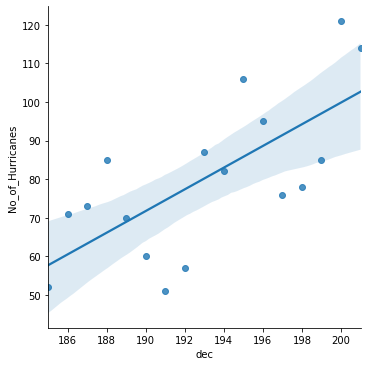

In [10]:
import seaborn as sns
sns.lmplot(x='dec', y='No_of_Hurricanes',data=df_dec50, ci=95)


In [11]:
from statsmodels.formula.api import ols
model=ols('No_of_Hurricanes ~ dec', data=df_dec50).fit()
print(model.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


                            OLS Regression Results                            
Dep. Variable:       No_of_Hurricanes   R-squared:                       0.485
Model:                            OLS   Adj. R-squared:                  0.451
Method:                 Least Squares   F-statistic:                     14.14
Date:                Thu, 04 Feb 2021   Prob (F-statistic):            0.00189
Time:                        23:44:25   Log-Likelihood:                -69.207
No. Observations:                  17   AIC:                             142.4
Df Residuals:                      15   BIC:                             144.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -462.3995    144.321     -3.204      0.0

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))


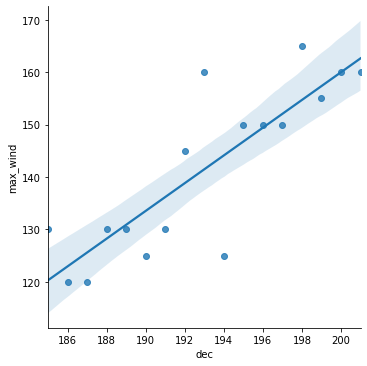

In [12]:
sns.lmplot(x='dec', y='max_wind',data=df_dec50, ci=95)

In [13]:
model=ols('max_wind ~ dec', data=df_dec50).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               max_wind   R-squared:                       0.717
Model:                            OLS   Adj. R-squared:                  0.698
Method:                 Least Squares   F-statistic:                     37.97
Date:                Thu, 04 Feb 2021   Prob (F-statistic):           1.82e-05
Time:                        23:44:25   Log-Likelihood:                -59.790
No. Observations:                  17   AIC:                             123.6
Df Residuals:                      15   BIC:                             125.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -369.4118     82.937     -4.454      0.0

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))


##OLS for % of hurricanes that made landfall vs. decades

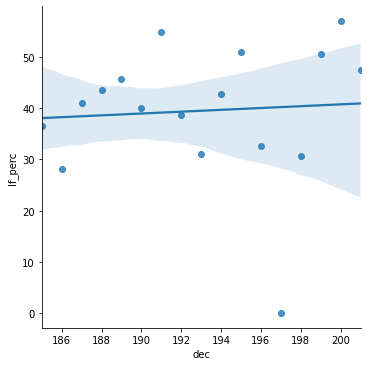

In [16]:
sns.lmplot(x='dec', y='lf_perc',data=df_dec50, ci=95)

In [17]:
model=ols('lf_perc ~ dec', data=df_dec50).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                lf_perc   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.062
Method:                 Least Squares   F-statistic:                   0.06966
Date:                Thu, 04 Feb 2021   Prob (F-statistic):              0.795
Time:                        23:44:26   Log-Likelihood:                -67.531
No. Observations:                  17   AIC:                             139.1
Df Residuals:                      15   BIC:                             140.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.0012    130.772      0.038      0.9

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))


#T-test

We'll do a t-test to compare the last two decades (200 and 201) to the years 1850-1999. Our null hypothesis is that the mean of the maximum wind for hurricanes in decade 200 is the same as the mean of the maximum wind for all previous decades combined (control:

H$_0$: $\mu_{200} = \mu_{control}$

H$_a$: $\mu_{200} \neq \mu_{control}$

Same for decade 201 (note control remains the same and does not include decade 200):

H$_0$: $\mu_{201} = \mu_{control}$

H$_a$: $\mu_{201} \neq \mu_{control}$

In [18]:
twohund=df_hur50.loc[(df_hur50['dec']==200), 'max_wind']
twoohone=df_hur50.loc[(df_hur50['dec']==201), 'max_wind']
control=df_hur50.loc[(df_hur50['dec']<200), 'max_wind']
from scipy import stats as st

twohund_tval, twohund_pval=st.ttest_ind(twohund,control,equal_var=False,nan_policy='omit')
twohund_tval,twohund_pval

twoohone_tval, twoohone_pval=st.ttest_ind(twoohone,control,equal_var=False,nan_policy='omit')
twoohone_tval,twoohone_pval


print('p-value for max_wind in decade 200:', twohund_pval)
print('')
print('p-value for max_wind in decade 201:', twoohone_pval)
# control

p-value for max_wind in decade 200: 0.5419853063370423

p-value for max_wind in decade 201: 0.6806812340452624


####We fail to reject the null hypothesis, there is no statistical difference between the mean wind speed of hurricanes the past two decades compared to prior decades.

###We'll perform the same test with the control group decades < 1950's 

In [19]:
twohund=df_hur50.loc[(df_hur50['dec']==200), 'max_wind']
twoohone=df_hur50.loc[(df_hur50['dec']==201), 'max_wind']
control=df_hur50.loc[(df_hur50['dec']<194), 'max_wind']
from scipy import stats as st

twohund_tval, twohund_pval=st.ttest_ind(twohund,control,equal_var=False,nan_policy='omit')
twohund_tval,twohund_pval

twoohone_tval, twoohone_pval=st.ttest_ind(twoohone,control,equal_var=False,nan_policy='omit')
twoohone_tval,twoohone_pval


print('p-value for max_wind in decade 200:', twohund_pval)
print('')
print('p-value for max_wind in decade 201:', twoohone_pval)


p-value for max_wind in decade 200: 0.41270143665594616

p-value for max_wind in decade 201: 0.5277779893646224


###On both cases we fail to reject the null hypothesis, which is interesting because when testing for the same two variables with OLS, we reject the null hypothesis at a 95% alpha level.

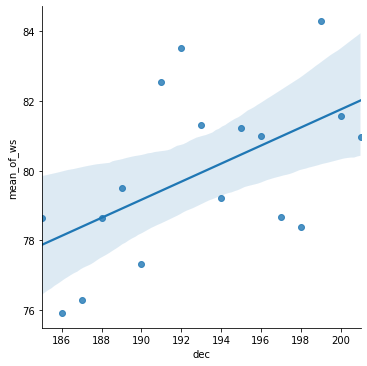

In [14]:
sns.lmplot(x='dec', y='mean_of_ws',data=df_dec50, ci=95)

In [15]:
model=ols('mean_of_ws ~ dec', data=df_dec50).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             mean_of_ws   R-squared:                       0.300
Model:                            OLS   Adj. R-squared:                  0.253
Method:                 Least Squares   F-statistic:                     6.420
Date:                Thu, 04 Feb 2021   Prob (F-statistic):             0.0229
Time:                        23:44:26   Log-Likelihood:                -35.367
No. Observations:                  17   AIC:                             74.73
Df Residuals:                      15   BIC:                             76.40
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     30.0067     19.716      1.522      0.1

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))


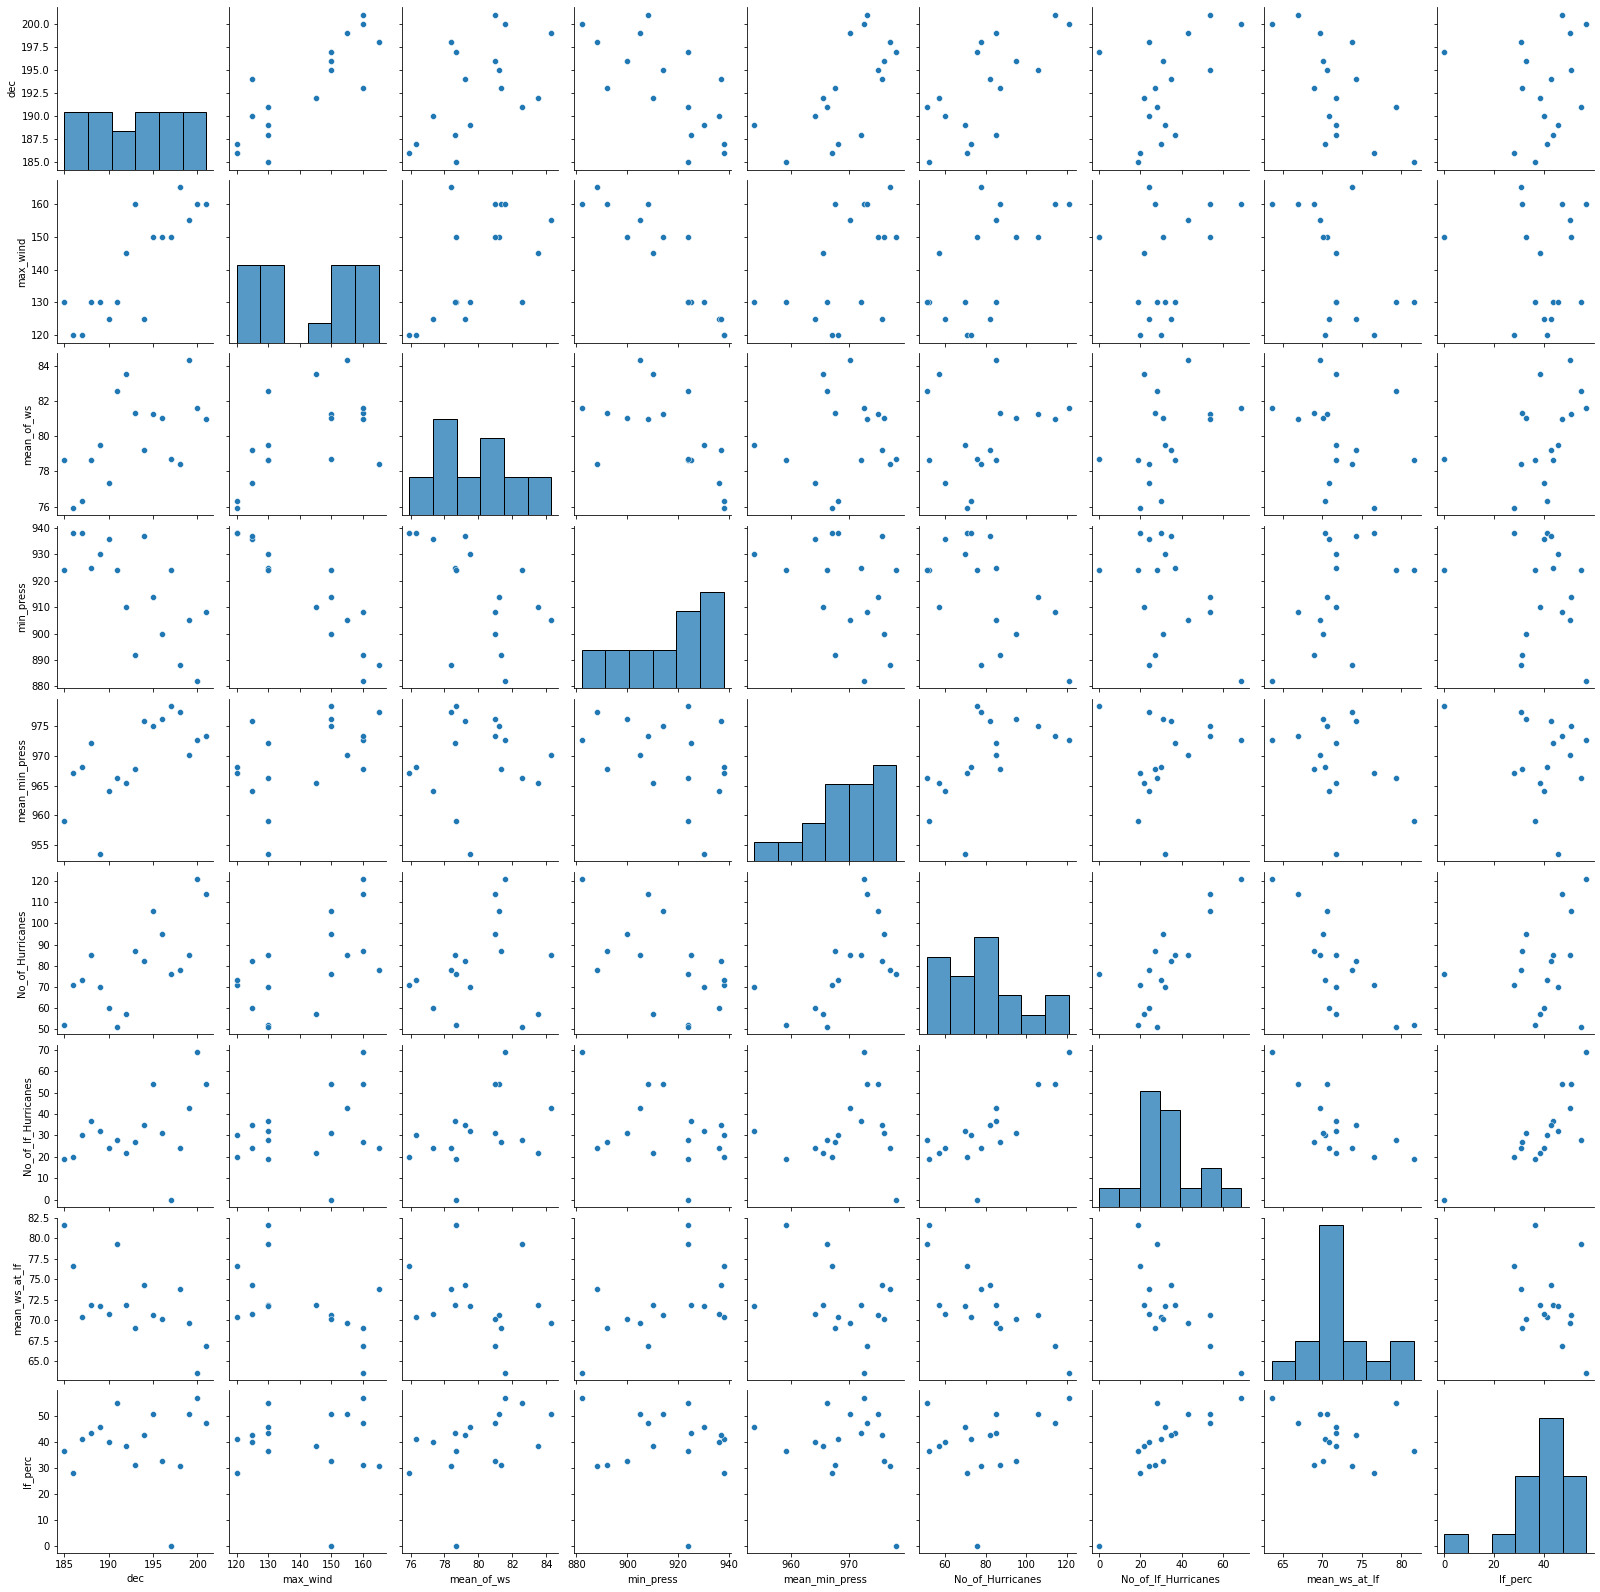

In [20]:
import seaborn as sns
sns.pairplot(df_dec50)

#Extra

There is a curious correlation between the mean wind-speed at landfall and the number of hurricanes that made landfall.

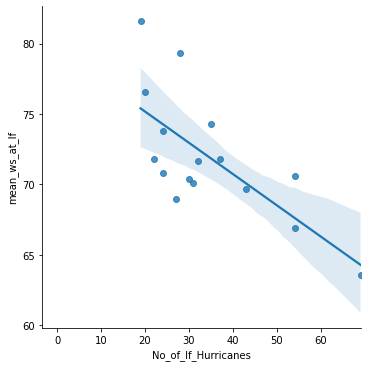

In [21]:
sns.lmplot(x='No_of_lf_Hurricanes', y='mean_ws_at_lf',data=df_dec50, ci=95)


In [22]:
from statsmodels.formula.api import ols
model=ols('mean_ws_at_lf ~ No_of_lf_Hurricanes', data=df_dec50).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          mean_ws_at_lf   R-squared:                       0.500
Model:                            OLS   Adj. R-squared:                  0.464
Method:                 Least Squares   F-statistic:                     13.98
Date:                Thu, 04 Feb 2021   Prob (F-statistic):            0.00220
Time:                        23:45:01   Log-Likelihood:                -40.498
No. Observations:                  16   AIC:                             85.00
Df Residuals:                      14   BIC:                             86.54
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              79.6238    

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))
